# Figure 9: Test statistic vs detection uncertainty

<div style="text-align: justify">
This code is used to create **Figure 8** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The Figure shows the which value of the test statistic $T_{\text{obs}}$ is needed to reach a certain confidence level for the planet detection. Depending on the assumption we make about the noise this relationship can be very different.
</div>

## Imports

In [1]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from applefy.statistics import fpf_2_gaussian_sigma, gaussian_sigma_2_fpf, TTest, LaplaceBootstrapTest
from applefy.detections.contrast import ContrastResult
from applefy.utils.positions import get_number_of_apertures
from applefy.utils.photometry import estimate_stellar_flux
from applefy.utils.file_handling import read_apples_with_apples_root

## Restore the lookup tables

<div style="text-align: justify">
We want to compare show the relationship between $T_{\text{obs}}$ and the confidence level under the assumption of Laplacian and Gaussian noise. For this we restore the [previously computed](../../02_user_documentation/03_bootstrapping.ipynb) lookup tables for the [LaplaceBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest) and create a [TTest](../../03_package/statistics.rst#applefy.statistics.parametric.TTest).
</div>

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


Create the TTest.

In [3]:
ttest_statistic = TTest()

Restore the LaplaceBootstrapTest from the lookup tables.

In [4]:
# Setup the tests
pbs_laplace_statistic = LaplaceBootstrapTest.construct_from_json_file(
    os.path.join(experiment_root, "lookup_tables/laplace_lookup_tables.csv"))

## Compute the required $T_{\text{obs}}$

<div style="text-align: justify">
We want to compute the required values of $T_{\text{obs}}$ as a function of the separation from the star. At large separations we have more noise values (apertures) and the effect of small sample statistics is less important. We compute the results for two different detection thresholds: $5\sigma_{\mathcal{N}} = 2.87 \times 10^{-7}$ and $3\sigma_{\mathcal{N}} = 1.35 \times 10^{-3}$.
</div>

In [5]:
# Compute the number of noise values available for the different separations
separations_lambda_D = np.arange(1, 20.5, 0.5)
num_noise_values = [get_number_of_apertures(2*i, 1) - 1 
                    for i in separations_lambda_D]

Compute the values of $T_{\text{obs}}$ for the *LaplaceBootstrapTest* and the *TTest*.

In [6]:
req_T_ttest3 = []
req_T_laplace3 = []
req_T_ttest5 = []
req_T_laplace5 = []

for tmp_num_noise in num_noise_values:
    req_T_ttest3.append(
        ttest_statistic.fpf_2_t(
            gaussian_sigma_2_fpf(3), 
            tmp_num_noise))
    
    req_T_laplace3.append(
        pbs_laplace_statistic.fpf_2_t(
            gaussian_sigma_2_fpf(3), 
            tmp_num_noise))
    
    req_T_ttest5.append(
        ttest_statistic.fpf_2_t(
            gaussian_sigma_2_fpf(5), 
            tmp_num_noise))
    
    req_T_laplace5.append(
        pbs_laplace_statistic.fpf_2_t(
            gaussian_sigma_2_fpf(5), 
            tmp_num_noise))

## Create the Plot

Define the colors used in the plot.

In [7]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1]]

A small function to plot one of the two subplots.

In [8]:
def plot_snr(results_ttest,
             results_laplace,
             confidence,
             axis_in):
    
    axis_in.plot(separations_lambda_D, 
                 results_ttest, 
                 label="t-Test (Gauss)",
                 color=color_palette[0],
                 lw=3)

    axis_in.plot(separations_lambda_D, 
                 results_laplace, 
                 label="Parametric BS (Laplace)",
                 color=color_palette[1],
                 lw=3)
    
    # Plot the convergence line for the TTest
    axis_in.axhline(confidence, lw=2, ls="--", color="black")
    axis_in.grid()
    
    # The positions of the label box in the plot
    if confidence == 5:
        a = 20.7
    else:
        a = 8.5
    
    axis_in.text(
        14, a, r" ... with ${} \sigma_{{\mathcal{{N}}}}$"\
        " Confidence".format(str(confidence)),
        ha="center", fontsize=14, fontweight="bold",
        bbox=dict(facecolor='white', edgecolor='grey', 
                  boxstyle='round,pad=0.5'))

Create the actual plot.

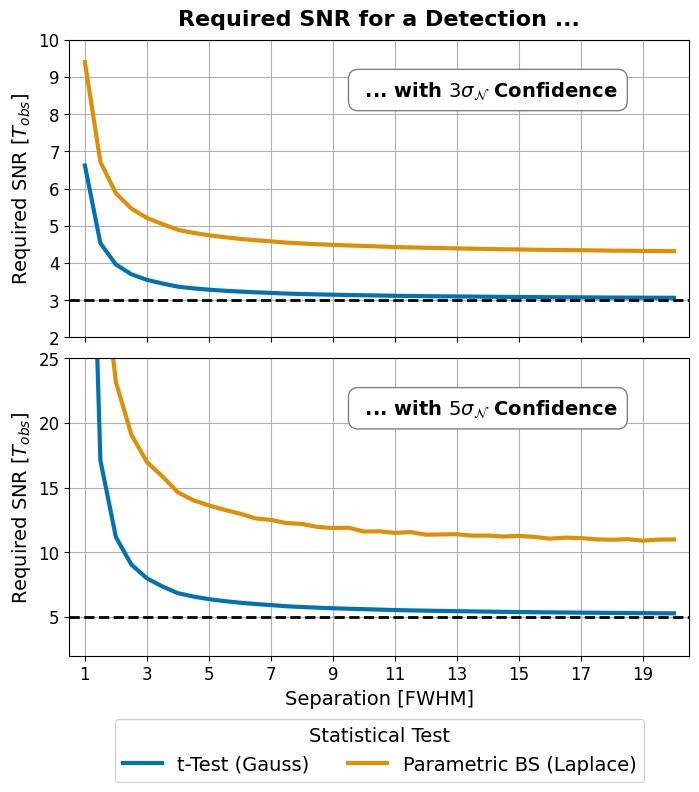

In [9]:
# 1.) Create Plot Layout ------------------------------------
fig = plt.figure(constrained_layout=False, 
                 figsize=(8, 8))

gs0 = fig.add_gridspec(2, 1)
gs0.update(hspace=0.07, wspace=0.09)

axis_rq_T3 = fig.add_subplot(gs0[0, 0])
axis_rq_T5 = fig.add_subplot(gs0[1, 0])

# 2.) Make the plot 3 sigma  --------------------------------
plot_snr(req_T_ttest3, 
         req_T_laplace3, 
         3, axis_rq_T3)
plot_snr(req_T_ttest5, 
         req_T_laplace5, 
         5, axis_rq_T5)

# 3.) Set limits  -------------------------------------------
axis_rq_T5.set_ylim(2, 25)
axis_rq_T5.set_xlim(0.5, 20.5)

axis_rq_T3.set_ylim(2, 10)
axis_rq_T3.set_xlim(0.5, 20.5)

axis_rq_T3.set_xticks(np.arange(1, 20, 2))
axis_rq_T5.set_xticks(np.arange(1, 20, 2))

axis_rq_T3.tick_params(
    axis='both', which='major', labelsize=12)
axis_rq_T5.tick_params(
    axis='both', which='major', labelsize=12)

# 4.) Set Labels  -------------------------------------------
plt.setp(axis_rq_T3.get_xticklabels(), visible=False)

axis_rq_T5.set_xlabel(r"Separation [FWHM]", size=14)
axis_rq_T5.set_ylabel(r"Required SNR [$T_{obs}$]", size=14)
axis_rq_T3.set_ylabel(r"Required SNR [$T_{obs}$]", size=14)

axis_rq_T3.set_title("Required SNR for a Detection ...",
                     fontsize=16, fontweight="bold", y=1.02)

# 5.) Legend  -----------------------------------------------
handles, labels = axis_rq_T5.get_legend_handles_labels()

leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.17, -0.06), 
                  fontsize=14, 
                  title="Statistical Test",
                  loc='lower left', ncol=2)
plt.setp(leg1.get_title(),fontsize=14)

# 5.) Save the Plot  ----------------------------------------
fig.patch.set_facecolor('white')
plt.savefig("./09_Required_SNR.pdf", 
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')